<h2>개인 구글 드라이브와 colab 연동</h2>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


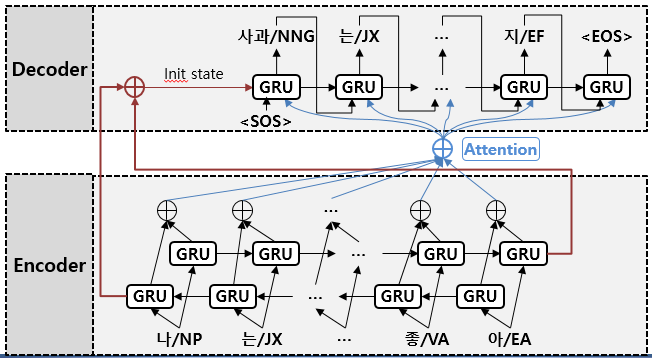

In [2]:
from IPython.display import Image
Image("/gdrive/My Drive/colab/DNN_RNN/seq2seq/seq2seq.PNG")

<h2>Seq2Seq_Decoder Model</h2>

In [3]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
#Class 2개: Decoder, seq2seq(Encoder+Decoder실행)

#Decorder 계산 구현
class Decoder(nn.Module):
    def __init__(self, config, embedding):
        super(Decoder, self).__init__()
        
        # 단어 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # GRU 히든 사이즈
        self.hidden_size = config["hidden_size"]

        # 전체 어휘 개수
        self.vocab_size = config["vocab_size"]

        self.embedding = embedding
        self.dropout = nn.Dropout(config["dropout"])

        # GRU layer
        self.gru = nn.GRU(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=1)   #단방향 GRU
        self.linear_1 = nn.Linear(in_features=self.hidden_size*2, out_features=self.hidden_size)        #현재 GRU 출력값과 Context vector를 hidden size로 치환해주는 선형함수
        self.linear_2 = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)           #어휘의 확률 분포를 얻기 위해 hidden size를 vocab_size로 바꿔주는 선형함수

    def forward(self, input, last_hidden, encoder_outputs):                         #input:디코더에 들어가는 인풋, last_hidden:최신 히든스테이트 값 담은 부분
        # (batch_size, 1) -> (1, batch_size, embedding_size)                         encoder_outputs: 인코더 각 스텝의 아웃풋 --> 어텐션에 활용됨
        embedded = self.embedding(input).unsqueeze(0)  # (1,B,N)                   
        embedded = self.dropout(embedded)              # 임배딩에도 dropout 적용 (일반화된 정보 뽑기 위해)

        # rnn_output : (1, batch_size, hidden_size)
        # hidden : (1, batch_size, hidden_size)
        rnn_output, hidden = self.gru(embedded, last_hidden)                        #input: 단어벡터와 디코더의 hidden state 값

        # (1, batch_size, hidden_size) -> (batch_size, 1, hidden_size)
        rnn_output_for_attention = rnn_output.transpose(0, 1).contiguous()          #.contiguous(): 별도의 메모리에 저장
        # (curr_max_length, batch_size, hidden_size) -> (batch_size, hidden_size, curr_max_length)
        encoder_outputs = encoder_outputs.permute(1, 2, 0)

        # (batch_size, 1, hidden_size) -> (batch_size, 1, curr_max_length)
        attn_weights = rnn_output_for_attention.bmm(encoder_outputs)                #바로 위의 두 벡터를 내적한 것(행렬곱) --> Attention weight

        # (batch_size, curr_max_length) -> (batch_size, 1, curr_max_length)
        attn_weights = F.softmax(attn_weights, dim=-1)                              #softmax함수로 0~1 사이 확률값으로 변환

        # (batch_size, 1, curr_max_length) * (batch_size, curr_max_length, hidden_size) 
        # -> (batch_size, 1, hidden_size)
        context = attn_weights.bmm(encoder_outputs.transpose(1, 2))                 #웨이트와 아웃풋을 가중합하여 context vector를 구함

        # rnn_output : (1, batch_size, hidden_size) -> (batch_size, hidden_size)
        # context : (batch_size, 1, hidden_size) -> (batch_size, hidden_size)
        rnn_output, context = rnn_output.squeeze(0), context.squeeze(1)             #concatenate을 위해 형태를 맞춰줌

        # (batch_size, hidden_size*2)
        concat_input = torch.cat(tensors=(rnn_output, context), dim=-1)

        # (batch_size, hidden_size*2) -> (batch_size, hidden_size)
        concat_output = torch.tanh(self.linear_1(concat_input))

        # (batch_size, hidden_size) -> (batch_size, vocab_size)
        output = self.linear_2(concat_output)

        return output, hidden   #확률분포값, 현재의 히든스테이트 값

#전체 흐름.
class Seq2Seq(nn.Module):
    def __init__(self, config):
        super(Seq2Seq, self).__init__()

        # 전체 어휘 개수
        self.vocab_size = config["vocab_size"]
        
        # 단어 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # GRU 히든 사이즈
        self.hidden_size = config["hidden_size"]
        
        # 입력 sequence의 최대 길이
        self.max_length = config["max_length"]

        # 입력 데이터에 있는 각 단어 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        # 기존에 사전학습 된 단어 임베딩을 사용할 수도 있고 랜덤으로 초기화 한 후,
        # 모델 학습 과정 중에 같이 학습 시키는 것도 가능
        # 예제 코드는 랜덤으로 초기화 한 후 같이 학습하도록 설정
        self.word_embedding = nn.Embedding(num_embeddings=self.vocab_size,
                                           embedding_dim=self.embedding_size,
                                           padding_idx=0)

        # Bi-GRU layer
        self.bi_gru_layer1 = nn.GRU(input_size=self.embedding_size,
                             hidden_size=self.hidden_size // 2,     #양방향이므로 num_hidden/2를 출력
                             num_layers=1,
                             bidirectional=True)
        
        self.bi_gru = nn.GRU(input_size=self.embedding_size,
                             hidden_size=self.hidden_size // 2,     #양방향이므로 num_hidden/2를 출력
                             num_layers=1,
                             bidirectional=True)


        # Decoder layer
        self.decoder = Decoder(config, self.word_embedding)         #Decoder에서도 이전 단계의 output을 Embedding하여 input으로 사용하므로 word_embedding 필요함

        self.dropout = nn.Dropout(config["dropout"])


    def forward(self, input_features, output_features=None):
        batch_size = input_features.size()[0]

        # 입력 sequence의 실제 길이
        input_feature_lengths = (input_features != 0).sum(dim=-1)            #Padding은 0이므로 길이에서 제외(True:1 False:0 이므로 조건문 결과를 마지막 차원 기준 sum)

        # (batch_size, max_length) -> (batch_size, max_length, embedding_size)
        input_features = self.word_embedding(input_features)
        # (batch_size, max_length, embedding_size) -> (max_length, batch_size, embedding_size)
        input_features = input_features.transpose(0, 1)

        layer1_packed_input_features = pack_padded_sequence(input_features, input_feature_lengths.cpu(), batch_first=False, enforce_sorted=False)
        layer1_packed_gru_outputs, layer1_gru_hidden_states = self.bi_gru_layer1(layer1_packed_input_features)                      #gru_hidden_states: Encoding Final step 결과(2개:양방향이라서)
        layer1_outputs_unpacked, layer1_input_lengths_unpacked = pad_packed_sequence(layer1_packed_gru_outputs, batch_first=False) #각 스텝의 출력값

        ################################### Layer1 --> Layer2 #####################################
        layer2_input_features = torch.cat(tensors=(layer1_outputs_unpacked, input_features), dim= 0)

        packed_input_features = pack_padded_sequence(layer2_input_features, input_feature_lengths.cpu(), batch_first=False, enforce_sorted=False)
        packed_gru_outputs, gru_hidden_states = self.bi_gru(packed_input_features)                      #gru_hidden_states: Encoding Final step 결과(2개:양방향이라서)
        gru_outputs_unpacked, input_lengths_unpacked = pad_packed_sequence(packed_gru_outputs, batch_first=False) #각 스텝의 출력값

        # (2, batch_size, hidden_size/2) -> (batch_size, hidden_size)
        gru_hidden_states = torch.cat(tensors=(gru_hidden_states[0], gru_hidden_states[1]), dim=-1)         #순/역방향 Final step의 output을 concatenate (context vector)

        # gru_outputs_unpacked : (curr_max_length, batch_size, hidden_size)
        # gru_hidden_states : (batch_size, hidden_size)
        gru_outputs_unpacked, gru_hidden_states = self.dropout(gru_outputs_unpacked), self.dropout(gru_hidden_states)

        # (batch_size, ), 디코더의 시작 step 입력 값을 "--START--"로 초기화 (stary symbol --> index 1로 치환되어있음)
        decoder_input = torch.ones(size=(batch_size, ), dtype=torch.long).cuda() #-->.cuda()를 통해 gpu메모리에 업로드
        # (batch_size, hidden_size) -> (1, batch_size, hidden_size)
        decoder_hidden = gru_hidden_states.unsqueeze(0)             #unsqueeze를 통해 한차원 증가(그냥 decorder 파트에 넣기 위해 형태 맞춰준 것)
        decoder_outputs = []
        if(output_features is not None):                            #정답이 주어졌을 때, Train 시 Decorder 부분 학습 
            for step in range(self.max_length):
                # decoder_output : (batch_size, vocab_size)
                # decoder_hidden : (1, batch_size, hidden_size)
                decoder_output, decoder_hidden = self.decoder(decoder_input,        # 1로 초기화된 start symbol (첫번째 스텝의 인풋)
                                                              decoder_hidden,       # Encorder에서 구한 양방향에서의 마지막 상태값
                                                              gru_outputs_unpacked) # 인코더의 각각 스텝의 출력값 -->어탠션에 활용
                                                                                    #decoder_output:출력단어의 확률분포 decoder_hidden:한 스텝이 진행된 후 상태값
                decoder_input = output_features[:, step]                            #Train 시에는 정답을 Decoder input으로 쓰기 때문에
                decoder_outputs.append(decoder_output)                              

            # (max_length, batch_size, vocab_size)
            decoder_outputs = torch.stack(tensors=decoder_outputs, dim=0)           #리스트 안에 각각의 텐서로 저장되어있는 것을 하나의 텐서로 묶어준다.
            # (max_length, batch_size, vocab_size) -> (batch_size, max_length, vocab_size)
            decoder_outputs = decoder_outputs.transpose(0, 1)                       #그냥 익숙한 형태로 다시 변환

            loss_fct = nn.CrossEntropyLoss()

            # (batch_size, max_length, vocab_size) -> (batch_size*max_length, vocab_size)
            decoder_outputs = decoder_outputs.reshape(shape=(-1, self.vocab_size))  #Loss 구하기 위해 2차원으로 변환
            # (batch_size, max_length) -> (batch_size*max_length)
            output_features = output_features.flatten()                             #정답을 1차원으로

            loss = loss_fct(decoder_outputs, output_features)

            return loss
        else:
            for t in range(self.max_length):
                # decoder_output : (batch_size, vocab_size)
                # decoder_hidden : (1, batch_size, hidden_size)
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, gru_outputs_unpacked)

                # (batch_size, vocab_size) -> (batch_size, )
                decoder_input = decoder_output.argmax(dim=-1)                   #테스트에서는 이전의 output을 인풋으로 사용.
                decoder_outputs.append(decoder_output.argmax(dim=-1))           

            # (max_length, batch_size, vocab_size)
            decoder_outputs = torch.stack(tensors=decoder_outputs, dim=0)
            # (max_length, batch_size, vocab_size) -> (batch_size, max_length, vocab_size)
            decoder_outputs = decoder_outputs.transpose(0, 1)

            return decoder_outputs

<h2>데이터 읽고 전처리 하기</h2>

<pre>
<b>1. read_file(file_path)</b>
  "train.txt", "test.txt" 파일을 읽기 위한 함수
  
  데이터 예시)
    나/NP ＜SP＞ 무지/NNG ＜SP＞ 슬퍼./NA \t 슬퍼하/VV 지/EC ＜SP＞ 말어요..*/NA
  
  read_file(file_path)
  args
    file_path : 읽고자 하는 데이터의 경로
  return
    입력 sequence와 출력 sequence를 담고 있는 리스트
    
    출력 예시)
      datas = [
        (["나/NP", "＜SP＞", "무지/NNG", "＜SP＞", "슬퍼./NA"], ["슬퍼하/VV", "지/E", "＜SP＞", "말어요..*/NA"])

        (...),
        
        ]
      
<b>2. read_vocab_data(vocab_file_path)</b>
  "vocab.txt" 파일을 읽고 형태소를 indexing하기 위한 딕셔너리를 생성
   
  read_vocab_data(vocab_file_path)
  args
    vocab_file_path : 형태소 어휘 파일 경로
  return
    word2idx, idx2word 딕셔너리
    
    word2idx : 형태소를 대응하는 index로 치환하기 위한 딕셔너리
    idx2word : index를 대응하는 형태소로 치환하기 위한 딕셔너리
    
<b>3. convert_data2feature(datas, max_length, word2idx)</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  Tensor로 변환
   
  convert_data2feature(datas, max_length, word2idx)
  args
    datas : 입력 sequence와 출력 sequence를 담고 있는 리스트
    max_length : sequence의 최대 길이
    word2idx : 형태소를 대응하는 index로 치환하기 위한 딕셔너리
  return
    입력 데이터와 각각의 데이터의 실제 길이를 담고 있는 Tensor
    
  전처리 예시)
    datas = [
    (["나/NP", "＜SP＞", "무지/NNG", "＜SP＞", "슬퍼./NA"], ["슬퍼하/VV", "지/E", "＜SP＞", "말어요..*/NA"]),

    (...),
    
    ]
    
    사전 설정한 문장의 최대 길이를 10이라고 가정
    
    ["나/NP", "＜SP＞", "무지/NNG", "＜SP＞", "슬퍼./NA"] -> ["나/NP", "＜SP＞", "무지/NNG", "＜SP＞", "슬퍼./NA", "＜PAD＞", "＜PAD＞", "＜PAD＞", "＜PAD＞", "＜PAD＞"]
    ["나/NP", "＜SP＞", "무지/NNG", "＜SP＞", "슬퍼./NA", "＜PAD＞", "＜PAD＞", "＜PAD＞", "＜PAD＞", "＜PAD＞"] -> [ 23, 5, 3, 5, 65, 0, 0, 0, 0, 0 ]
    
    ["슬퍼하/VV", "지/E", "＜SP＞", "말어요..*/NA"] -> ["슬퍼하/VV", "지/E", "＜SP＞", "말어요..*/NA", "＜END＞", "＜PAD＞", "＜PAD＞", "＜PAD＞", "＜PAD＞", "＜PAD＞"]
    ["슬퍼하/VV", "지/E", "＜SP＞", "말어요..*/NA", "＜END＞", "＜PAD＞", "＜PAD＞", "＜PAD＞", "＜PAD＞", "＜PAD＞"] -> [ 2, 10, 5, 10, 3, 0, 0, 0, 0, 0 ]    

    input_features : Tensor([ 23, 5, 3, 5, 65, 0, 0, 0, 0, 0 ], [...], ...)
    output_features : Tensor([ 2, 10, 5, 10, 3, 0, 0, 0, 0, 0 ], [...], ...)
*입력 시퀀스는 End Symbol 필요 없지만 출력 시퀀스는 End Symbol 필요!!!    
 </pre>


In [4]:
import torch
import numpy as np
from tqdm import tqdm


# 학습 or 평가 데이터를 읽어 리스트에 저장
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    datas = []
    for line in tqdm(lines, desc="read_data"):
        # 입력 문장을 \t으로 분리
        pieces = line.strip().split("\t")

        # 데이터의 형태가 올바른지 체크
        assert len(pieces) == 2

        # 입력 문자열을 형태소 단위로 분리
        question, answer = pieces[0].split(), pieces[1].split()

        datas.append((question, answer))

    return datas


# 데이터를 읽고 각각의 딕셔너리 생성
def read_vocab_data(vocab_data_path):
    word2idx, idx2word = {}, {}

    with open(vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        word = line.strip()
        word2idx[word] = len(word2idx)
        idx2word[word2idx[word]] = word

    return word2idx, idx2word


# 입력 데이터 전처리
def convert_data2feature(datas, max_length, word2idx):
    # 입력 데이터, 출력 데이터를 담을 리스트
    input_features, output_features = [], []

    for input_sequence, output_sequence in tqdm(datas, desc="convert_data2feature"):
        # 사전 설정한 max_length의 길이를 갖는 numpy array 생성
        input_feature, output_feature = np.zeros(shape=(max_length), dtype=np.int), np.zeros(shape=(max_length), dtype=np.int)

        # 입력 sequence의 각 값들을 index로 치환하고 위에서 생성한 numpy array에 저장
        for index in range(len(input_sequence[:max_length])):
            input_feature[index] = word2idx[input_sequence[index]]

        # 출력 sequence의 각 값들을 index로 치환하고 위에서 생성한 numpy array에 저장
        for index in range(len(output_sequence[:max_length])):
            output_feature[index] = word2idx[output_sequence[index]]
        # 출력 sequence의 마지막 부분에 "--END--" 추가
        output_feature[index+1] = word2idx["--END--"]

        # 변환한 데이터를 각 리스트에 저장
        input_features.append(input_feature)
        output_features.append(output_feature)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_features = torch.tensor(input_features, dtype=torch.long)
    output_features = torch.tensor(output_features, dtype=torch.long)

    return input_features, output_features

<h2>Seq2Seq 모델 학습</h2>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 학습 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, word2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. Seq2Seq 모델 객체 선언</b>

<b>5. epoch를 돌때마다 모델 파일 저장</b>

<b>**기존과 다른 부분> 원래는 한 epoch 돌 때마다 성능측정 후 기존보다 성능이 좋을 때에만 모델 저장을 했음.
                  이번 실습같은 생성모델은 성능을 간접평가 or 정성적평가가 필요하므로 그냥 매 epoch 마다 저장하도록 code를 짜놨다.
                  그래서 이번에는 학습데이터를 train test로 나누지 않았다.</b>
</pre>

In [5]:
import os
import re
import numpy as np
from tqdm import tqdm

import torch
from torch.utils.data import (DataLoader, TensorDataset)
import torch.optim as optim


def train(config):
    # 학습 데이터 읽기
    train_datas = read_data(config["train_data_path"])

    # 어휘 딕셔너리 생성
    word2idx, idx2word = read_vocab_data(config["vocab_data_path"])

    # 입력 데이터 전처리
    train_input_features, train_output_features \
        = convert_data2feature(train_datas, config["max_length"], word2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_features, train_output_features)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    # Seq2Seq 모델 객체 생성, GPU 메모리에 적재
    model = Seq2Seq(config).cuda()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(config["epoch"]):                #epoch만큼 반복 
        model.train()

        losses = []
        for step, batch in enumerate(tqdm(train_dataloader, desc="epoch_{}_train".format(epoch + 1))):  #DataLoader에서 batch 단위로 데이터를 가져옴, 묶여있는 데이터를 변수마다 할당
            batch = tuple(t.cuda() for t in batch)

            # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
            input_features, output_features = batch[0], batch[1]

            # 모델 학습 (학습시 input, output 둘 다 검증 시에는 input만)
            loss = model(input_features, output_features)

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            losses.append(loss.data.item())

        torch.save(model.state_dict(), os.path.join(output_dir, "epoch_{}.pt".format(epoch + 1)))

        # epoch 별로 평균 loss 값 출력
        print("Average loss : {}\n".format(np.mean(losses)))

<h2>Seq2Seq 모델 평가</h2>

<pre>
<b>*평가가 어렵지만 임의의 testset 5개를 미리 만들어서 테스트 진행</b>
<b>1. read_data(file_path) 함수를 사용하여 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, word2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. Seq2Seq 모델 객체 선언</b>

<b>5. load_state_dict() 함수를 사용하여 학습한 모델 파일로부터 가중치를 불러옴</b>

<b>6. 5개의 평가 데이터에 대한 모델 출력 확인

</pre>

In [6]:
import os
from tqdm import tqdm
from torch.utils.data import (DataLoader, TensorDataset)

def test(config):
    # 평가 데이터 읽기
    test_datas = read_data(config["test_data_path"])

    # 어휘 딕셔너리 생성
    word2idx, idx2word = read_vocab_data(config["vocab_data_path"])

    test_input_features, test_output_features \
        = convert_data2feature(test_datas, config["max_length"], word2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_features, test_output_features)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=1)

    # Seq2Seq 모델 객체 생성
    model = Seq2Seq(config).cuda()
    # 사전학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))

    model.eval()

    for step, batch in enumerate(tqdm(test_dataloader, desc="test")):
        batch = tuple(t.cuda() for t in batch)

        # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
        input_features, output_features = batch[0], batch[1]

        # 모델 평가
        predicts = model(input_features)
        predicts, input_features = predicts[0], input_features[0]       #평가데이터는 batch_size가 1이므로 index = 0으로 데이터를 가져옴

        # Tensor를 gpu에서 메인메모리(cpu)로 옮기고 리스트로 변경
        predicts = predicts.cpu().numpy().tolist()
        input_features = input_features.cpu().numpy().tolist()

        if (step < 5):
          print()
          print("input_features : ", end=" ")
          for idx in input_features:
            word = idx2word[idx]

            if(word == "--PAD--"):
              break
            print(word, end=" ")
          print()

          print("predicts : ", end=" ")
          for idx in predicts:
            word = idx2word[idx]

            if(word == "--END--"):
              break
            print(word, end=" ")
          print()

In [8]:
if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/colab/DNN_RNN/seq2seq"
    output_dir = os.path.join(root_dir, "new_model")

    if(not os.path.exists(output_dir)):
        os.makedirs(output_dir)

    config = {"mode": "test",
              "trained_model_name": "epoch_{}.pt".format(75),
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "vocab_data_path": os.path.join(root_dir, "vocab.txt"),
              "vocab_size": 19353,
              "embedding_size": 100,
              "hidden_size": 100,
              "max_length": 52,
              "epoch": 300,
              "batch_size": 32,
              "dropout": 0.3
              }

    if (config["mode"] == "train"):
        train(config)
    else:
        test(config)


test: 100%|██████████| 5/5 [00:00<00:00, 22.25it/s]


input_features :  오늘/NNG <sp> 너무/MAG <sp> 기분/NNG 이/JKS <sp> 좋/VA 아/EC 
predicts :  오늘/NNG <sp> 경주/NNG <sp> 지역/NNG 은/JX <sp> 흐리/VV 고/EC <sp> 한두/MM <sp> 차례/NNG <sp> 비/NNG 가/JKS <sp> 오/VV 지/EC <sp> 않/VX 습니다/EC 

input_features :  내일/NNG <sp> 뭐/NNG 하/XSV 냐/EF ?/SF 
predicts :  전/NNG <sp> 값/NNG 으로/JKB <sp> 따지/VV ㄹ/ETM <sp> 수/NNB <sp> 있/VV 습니다/EC 

input_features :  오늘/NNG <sp> 점심/NNG <sp> 어떤/MM 거/NNB <sp> 먹/VV 었/EP 어/EF ?/SF 
predicts :  오늘/NNG <sp> 오늘/NNG <sp> 집/NNG 에서/JKB <sp> 오/VV 는/ETM <sp> MBCFM/SL <sp> 계절/NNG ,/SP <sp> 레인/NNG ,/SP <sp> 레인/NNG ,/SP <sp> 시아/NNG <sp> 일/NNB 이/VCP ㅂ니다/EC 

input_features :  심심/XR 하/XSA 다/EC 
predicts :  제/NP 가/JKS <sp> 쫌/NA <sp> 그래요/IC 

input_features :  나/NP <sp> 감기/NNG <sp> 걸리/VV ㄴ/ETM <sp> 것/NNB <sp> 같/VA 아/EC 
predicts :  그것/NP 이/JKS <sp> 잘/MAG <sp> 생기/VV 는/ETM <sp> 것/NNB 이/JKS <sp> 좋/VA 다고/EC <sp> 하/VV ㅂ니다/EC 


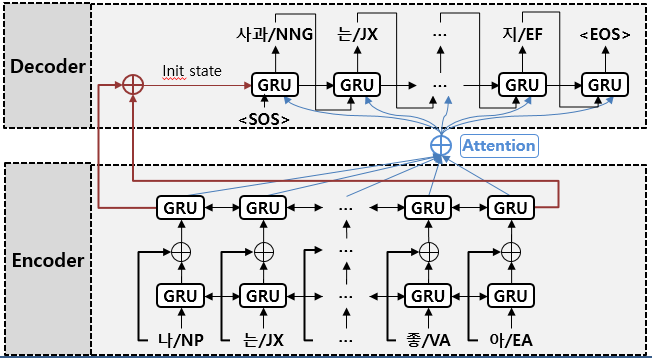

In [ ]:
from IPython.display import Image
Image("/gdrive/My Drive/colab/DNN_RNN/seq2seq/seq2seq_with_feature.PNG")